In [1]:
# Using this for cloud cover: https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

import ee
import geemap
import json
import os
import requests
from datetime import datetime
from datetime import date
from geemap import geojson_to_ee, ee_to_geojson
import geopandas as gpd 
import pandas as pd
import pickle
import math
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import statsmodels.api as sm
ee.Initialize()

In [2]:
#ee.Authenticate()

In [3]:
# Enter  start and end date as numbers for year, month, day
startDate = ee.Date.fromYMD(2022, 1, 1)
endDate = ee.Date.fromYMD(2022, 4, 30)
cloudFilter = 60
cloudProbabilityThreshold = 50
nirDarkThreshold = 0.15
cloudPProjectedDistance = 1
buffer = 50
# Distance in meters to shrink the plot polygons
shrinkBuffer = 20.0

outputPDF = "/home/nedhorning/RegenNetwork/fiberShed/GrazingReport2021_2022/KaosNorth2021_22_test_v2.pdf"
boundaryShp = "/home/nedhorning/RegenNetwork/fiberShed/GrazingReport2021_2022/KaosNorth1Aug2022UTM10.shp"


In [4]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        #.filterMetadata('MGRS_TILE', 'equals', '14SKJ')
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', cloudFilter)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        #.filterMetadata('MGRS_TILE', 'equals', '14SKJ')
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [5]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(cloudProbabilityThreshold).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

In [6]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(nirDarkThreshold*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, cloudPProjectedDistance *10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [7]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(buffer*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)
# return img.addBands(is_cld_shdw)

In [8]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [9]:
# Need to add cloud removal
def addNDVI(image):
  #image.updateMask(cloudmask)
  return image.addBands(image.normalizedDifference(['B8', 'B4']))

In [10]:
def getValues(fc):
    features = fc.getInfo()['features']
    dictarr = []
    for f in features:
        attr = f['properties']
        dictarr.append(attr)
    return dictarr

In [11]:
def wasGrazed(ndviAndDates, endOfGrazing, startOfGrazing):
    endOfGrazingDate = datetime.strptime(endOfGrazing, "%Y/%m/%d")
    startOfGrazingDate = datetime.strptime(startOfGrazing, "%Y/%m/%d")
    ndviDates = [datetime.strptime(d, "%Y_%m_%d") for d in ndviAndDates['ImageDate']]
    ndviDates_np = np.asarray(ndviDates)
    ndviVec = ndviAndDates['normalizedNDVI']
    ndviVec_np = ndviVec.to_numpy()
    quantNDVI50 = np.quantile(ndviVec_np, 0.5)
    greaterDates = ndviDates_np[np.where(ndviDates_np > endOfGrazingDate)]
    nextDate = greaterDates[np.where(abs(greaterDates-endOfGrazingDate) == min(abs(greaterDates-endOfGrazingDate)))]
    nextDateIndex = np.where(ndviDates_np == nextDate)
    lesserDates = ndviDates_np[np.where(ndviDates_np < endOfGrazingDate )]
    prevDate = lesserDates[np.where(abs(lesserDates-endOfGrazingDate) == min(abs(lesserDates-endOfGrazingDate)))]
    prevDateIndex = np.where(ndviDates == prevDate)
    sameDate = endOfGrazingDate in ndviDates_np
    
    lesserDatesStart = ndviDates_np[np.where(ndviDates_np < startOfGrazingDate )]
    prevDateStart = lesserDates[np.where(abs(lesserDatesStart-startOfGrazingDate) == min(abs(lesserDatesStart-startOfGrazingDate)))]
    prevDateIndexStart = np.where(ndviDates == prevDateStart)

    if ndviVec_np[prevDateIndexStart] < ndviVec_np[nextDateIndex]:
        grazed = False
    else:
        if sameDate: 
            lowNDVI = ndviVec_np[np.where(ndviDates_np == endOfGrazingDate)]
        else:
            lowNDVI = 999
        if ndviVec_np[nextDateIndex] < lowNDVI:
            lowNDVI = ndviVec_np[nextDateIndex]
        if ndviVec_np[prevDateIndex] < lowNDVI:
            lowNDVI = ndviVec_np[prevDateIndex]
        grazed = lowNDVI < quantNDVI50
    return grazed

In [12]:
boundary_ee = geemap.shp_to_ee(boundaryShp)
#boundary_buffered = boundary_ee.geometry().buffer(shrinkBuffer * -1.0)
boundary_bounds = boundary_ee.geometry().bounds()

In [13]:

#print(boundary_buffered.geometries().length().getInfo())

In [14]:
#boundary_buffered.geometries()[[1]].getInfo()
#boundary_buffered.coordinates().get(1).getInfo()

In [15]:
boundary_bounds.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-123.11079568312303, 38.96565506660988],
   [-123.08907723307648, 38.96565506660988],
   [-123.08907723307648, 38.99874036653208],
   [-123.11079568312303, 38.99874036653208],
   [-123.11079568312303, 38.96565506660988]]]}

In [16]:
s2_sr_cld_col = get_s2_sr_cld_col(boundary_bounds, startDate, endDate)

In [17]:
sentinelCollection = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .map(addNDVI))

In [18]:
datesObject = sentinelCollection.aggregate_array("system:time_start")
dateList =  datesObject.getInfo()
#print((dateList))
#print([datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d') for x in dateList])
dateList=[datetime.fromtimestamp(x/1000).strftime('%Y_%m_%d') for x in dateList]


In [19]:
print(dateList)
#print(sentinelCollection.first().bandNames().getInfo())

['2022_01_07', '2022_01_09', '2022_01_12', '2022_01_14', '2022_01_17', '2022_01_19', '2022_01_22', '2022_01_24', '2022_01_27', '2022_01_29', '2022_02_01', '2022_02_06', '2022_02_08', '2022_02_11', '2022_02_13', '2022_02_16', '2022_02_18', '2022_02_21', '2022_02_23', '2022_02_28', '2022_03_05', '2022_03_08', '2022_03_10', '2022_03_13', '2022_03_18', '2022_03_20', '2022_03_23', '2022_03_25', '2022_04_02', '2022_04_07', '2022_04_09', '2022_04_17', '2022_04_22', '2022_04_24', '2022_04_27', '2022_04_29']


In [20]:
sentinel_vis = {
    'min': 0,
    'max': 2500,
    'gamma': [1.1],
    'bands': ['B4', 'B3', 'B2']}

In [21]:
ndviViz = {'min': -0.5, 
           'max':0.9, 
           'bands': ['nd'],
           'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', \
                                               '99B718', '74A901', '66A000', '529400', '3E8601', \
                                               '207401', '056201', '004C00', '023B01', '012E01', \
                                               '011D01', '011301']}

In [22]:
ndviCollection = sentinelCollection.select('nd')
multiBandNDVI = ndviCollection.toBands()
multiBandNDVI = multiBandNDVI.rename(dateList)

In [23]:
boundaryList = boundary_ee.toList(1000)
print(boundaryList.length().getInfo())

19


In [24]:
# https://geemap.org/notebooks/select_features/#Printing-all-values-of-a-column
names = boundary_ee.aggregate_array("OBJECTID").getInfo()
print(names)
startDateTime = boundary_ee.aggregate_array("Start_Date").getInfo()
startDates = [x[0:10] for x in startDateTime]
startDatesDF = pd.DataFrame(startDates, columns=['startDate'])
endDateTime = boundary_ee.aggregate_array("End_Date").getInfo()
endDates = [x[0:10] for x in endDateTime]
print(startDatesDF)
print(endDates)
#print(names[0])
#print(len(names))

[99, 100, 101, 103, 105, 106, 107, 108, 112, 151, 185, 212, 213, 214, 215, 244, 281, 287, 293]
     startDate
0   2022/02/09
1   2022/02/07
2   2022/02/16
3   2022/02/15
4   2022/02/17
5   2022/02/20
6   2022/02/20
7   2022/02/21
8   2022/02/25
9   2022/02/27
10  2022/03/04
11  2022/03/12
12  2022/03/13
13  2022/03/01
14  2022/03/06
15  2022/03/18
16  2022/03/22
17  2022/03/26
18  2022/03/26
['2022/02/16', '2022/02/16', '2022/02/17', '2022/02/21', '2022/02/19', '2022/02/22', '2022/02/20', '2022/02/26', '2022/03/02', '2022/02/27', '2022/03/04', '2022/03/12', '2022/03/13', '2022/03/05', '2022/03/13', '2022/03/18', '2022/03/22', '2022/03/30', '2022/03/30']


In [25]:
type(names)

list

In [26]:
#parcel = boundary_ee.filter(ee.Filter.eq("OBJECTID", names[0]))

In [27]:
#parcel2 = ee.Feature(parcel).buffer(shrinkBuffer * -1.0)

In [28]:
allMeans = []  # List of dictionaries with date/mean ndvi pairs for each parcel (name)
allPixels = []  # List of dictionaries with date/number of valid pixels for each parcel 
allMaskedPixels = [] # List of dictionaries with date/number of all pixels for each parcel 
#allNames = []
names = boundary_ee.aggregate_array("OBJECTID").getInfo()

for index in range(0, len(names)):
    polygon = boundary_ee.filter(ee.Filter.eq("OBJECTID", names[index]))
    polygon_buffered = polygon.geometry().buffer(shrinkBuffer * -1.0)
    mean = multiBandNDVI.reduceRegion(
        reducer = ee.Reducer.mean(), 
        geometry = polygon_buffered,
        scale = 10
    )
    pixels = multiBandNDVI.reduceRegion(
        reducer = ee.Reducer.count(), 
        geometry = polygon_buffered,
        scale = 10
    )
    #unmaskedNDVI = multiBandNDVI.unmask(1)
    maskedPixels = multiBandNDVI.unmask(1).reduceRegion(
        reducer = ee.Reducer.count(), 
        geometry = polygon_buffered,
        scale = 10
    )
    #allNames.append(names[index])
    allMeans.append(mean.getInfo())  
    allPixels.append(pixels.getInfo())
    allMaskedPixels.append(maskedPixels.getInfo())

In [29]:
images = sentinelCollection.toList(sentinelCollection.size())

In [30]:
print(sentinelCollection.size().getInfo()-1)

35


In [31]:
'''
Map=geemap.Map()
Map.centerObject(boundary_bounds, 13)
for index in range(0, sentinelCollection.size().getInfo()):
    print("Processing " + dateList[index] + ": " + str(sentinelCollection.size().getInfo()-1 - index ) + " images to go      ", end = "\r")
    image = ee.Image(images.get(index))
#    mean = image.select('nd').reduceRegions(
#        reducer = ee.Reducer.mean(), 
#        geometry = boundary_buffered,
#        scale = 20
#    )
    Map.addLayer(image, sentinel_vis, dateList[index])
#Map.addLayer(boundary_buffered, {}, "Boundary EE")
Map.addLayer(boundary_ee, {}, "Boundary")
#Map.addLayer(parcel, {}, "Boundary")

# Display the map.
Map
'''

'\nMap=geemap.Map()\nMap.centerObject(boundary_bounds, 13)\nfor index in range(0, sentinelCollection.size().getInfo()):\n    print("Processing " + dateList[index] + ": " + str(sentinelCollection.size().getInfo()-1 - index ) + " images to go      ", end = "\r")\n    image = ee.Image(images.get(index))\n#    mean = image.select(\'nd\').reduceRegions(\n#        reducer = ee.Reducer.mean(), \n#        geometry = boundary_buffered,\n#        scale = 20\n#    )\n    Map.addLayer(image, sentinel_vis, dateList[index])\n#Map.addLayer(boundary_buffered, {}, "Boundary EE")\nMap.addLayer(boundary_ee, {}, "Boundary")\n#Map.addLayer(parcel, {}, "Boundary")\n\n# Display the map.\nMap\n'

In [32]:
#print(allMaskedPixels[14])

In [33]:
#allMaskedPixels[9].items()

In [34]:
#print(endDates)
#print(i)
type(dateList[1])

str

In [35]:
 print(allMeans[2].keys())

dict_keys(['2022_01_07', '2022_01_09', '2022_01_12', '2022_01_14', '2022_01_17', '2022_01_19', '2022_01_22', '2022_01_24', '2022_01_27', '2022_01_29', '2022_02_01', '2022_02_06', '2022_02_08', '2022_02_11', '2022_02_13', '2022_02_16', '2022_02_18', '2022_02_21', '2022_02_23', '2022_02_28', '2022_03_05', '2022_03_08', '2022_03_10', '2022_03_13', '2022_03_18', '2022_03_20', '2022_03_23', '2022_03_25', '2022_04_02', '2022_04_07', '2022_04_09', '2022_04_17', '2022_04_22', '2022_04_24', '2022_04_27', '2022_04_29'])


In [36]:
#type(dateMeans)
#len(plotDateMeans)
#sum(plotDateMeans)/len(plotDateMeans)
#len(endDates)


In [37]:
dateMeans = []

for x in range(0, len(dateList)):
    plotDateMeans = []
    for y in range(0, len(allMeans)):
        plotDateMeans.append(allMeans[y][dateList[x]])
    plotDateMeans = list(filter(None, plotDateMeans))
    if (len(plotDateMeans)) > 0:
        dateMeans.append(sum(plotDateMeans)/len(plotDateMeans))   
    else:
        dateMeans.append(0.0)   
        

In [38]:
print(allMeans)

[{'2022_01_07': None, '2022_01_09': 0.8400401561011704, '2022_01_12': 0.8335017305009581, '2022_01_14': 0.8453675984645589, '2022_01_17': 0.803416621430506, '2022_01_19': 0.8345450717172479, '2022_01_22': 0.8457835130472328, '2022_01_24': 0.8345210616308165, '2022_01_27': 0.5493839161326993, '2022_01_29': 0.5428450309574832, '2022_02_01': 0.5370343494155859, '2022_02_06': 0.5191469788367726, '2022_02_08': 0.5266012305644157, '2022_02_11': 0.5084391466024294, '2022_02_13': 0.47324241771752673, '2022_02_16': 0.4144681814398926, '2022_02_18': 0.4171019563948423, '2022_02_21': 0.4363204797466387, '2022_02_23': 0.45703029109869053, '2022_02_28': 0.37493751948558907, '2022_03_05': 0.4284507389883179, '2022_03_08': 0.429193516028642, '2022_03_10': 0.46204044019565876, '2022_03_13': 0.460600669606894, '2022_03_18': 0.47088022955185926, '2022_03_20': 0.5071164200218266, '2022_03_23': 0.5183252940284392, '2022_03_25': 0.5304076019720135, '2022_04_02': 0.4345714516103978, '2022_04_07': 0.45210832

In [39]:
#https://python-course.eu/matplotlib_subplots.php
m, n = 3, 2
counter = -1
start = date.fromtimestamp(startDate.getInfo()["value"]/1000)
end = date.fromtimestamp(endDate.getInfo()["value"]/1000)
with PdfPages(outputPDF) as pdf:
    f, axarr = plt.subplots(m, n, figsize=(8.5, 11))
    arr_ij = [(x, y) for x, y in np.ndindex(axarr.shape)]
    subplots = [axarr[index] for index in arr_ij]
    splot_index = 0
    for s, splot in enumerate(subplots):
        splot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(splot.get_xticklabels(), rotation = 15)
        plt.rcParams.update({"font.size": 5})
        
        splot.set_ylim(-0.3, 0.3)
        splot.set_xlim(start, end)
        splot.set_xlabel("Date")
        splot.set_ylabel("NDVI")
        #splot.set_title("Plot " + str(names[s]))
        
        
        splot.grid(axis="y")
        counter += 1
        if counter < len(endDates):
            if endDates[s] != '':
                splot.axvline(x=datetime.strptime(endDates[counter], "%Y/%m/%d"), c="firebrick")
                splot.axvline(x=datetime.strptime(startDates[counter], "%Y/%m/%d"), c="lawngreen")
                
    grazingHappened = np.zeros(len(endDates))
    #counter = (m * n) - 1
    for i in range(0, len(grazingHappened)):
        dateWithNDVI = pd.DataFrame(allMeans[i].items(), columns=['ImageDate', 'NDVI'])
        dateWithAllMaskedPixels = pd.DataFrame(allMaskedPixels[i].items(), columns=['ImageDate', 'AllMaskedPixels'])
        dateWithAllPixels = pd.DataFrame(allPixels[i].items(), columns=['ImageDate', 'AllPixels'])
        # Only use plots for a date with > 90% clear (no cloud or shadow) pixels
        normalizedNDVI = (dateWithAllPixels["AllPixels"] / dateWithAllMaskedPixels["AllMaskedPixels"] > 0.9) * (dateWithNDVI["NDVI"] - dateMeans)
        normalizedNDVI = normalizedNDVI.mask(np.isclose(normalizedNDVI.values, 0.0))
        dateWithNDVI['normalizedNDVI'] = normalizedNDVI.values
        dateWithNDVI_NoNA = dateWithNDVI.dropna(axis=0)
        dates_np = np.array([datetime.strptime(d, "%Y_%m_%d").date() for d in dateWithNDVI_NoNA['ImageDate']], dtype='datetime64')
        ndvi_np = np.array(dateWithNDVI_NoNA['normalizedNDVI'])
        if endDates[i] != '':
            
            grazingHappened[i]=wasGrazed(dateWithNDVI_NoNA, endDates[i], startDates[i])
        else:
            grazingHappened[i] = np.nan
        subplots[splot_index].plot(dates_np, ndvi_np)
        if math.isnan(grazingHappened[i]):
            verified = "NAN"
        elif grazingHappened[i] != 1.0:
            verified = "False"
        else:
            verified = "True"
        subplots[splot_index].set_title("Plot " + str(names[i]) + "(" + verified + ")")

        splot_index += 1
        if splot_index == m * n:
            plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,  wspace=0.25, hspace=0.5)
            pdf.savefig()
            plt.close(f)
            f, axarr = plt.subplots(m, n, figsize=(8.5, 11))
            arr_ij = [(x, y) for x, y in np.ndindex(axarr.shape)]
            subplots = [axarr[index] for index in arr_ij]
            splot_index = 0
            for s, splot in enumerate(subplots):
                splot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
                plt.setp(splot.get_xticklabels(), rotation = 15)
                plt.rcParams.update({"font.size": 5})
                splot.xaxis_date()
                splot.set_ylim(-0.3, 0.3)
                splot.set_xlim(start, end)
                splot.set_xlabel("Date")
                splot.set_ylabel("NDVI")
                #splot.set_title("Plot " + str(names[s+(m * n * (splot_index + 1))]))
                
                splot.grid(axis="y")
                counter += 1
                if counter < len(endDates):
                    if (endDates[counter] != ''):
                    #splot.axvline(x=datetime.strptime(endDates[s+(m * n * (splot_index + 1))], "%Y/%m/%d"), c="firebrick")
                    #splot.axvline(x=datetime.strptime(startDates[s+(m * n * (splot_index + 1))], "%Y/%m/%d"), c="lawngreen")
                        splot.axvline(x=datetime.strptime(endDates[counter], "%Y/%m/%d"), c="firebrick")
                        splot.axvline(x=datetime.strptime(startDates[counter], "%Y/%m/%d"), c="lawngreen")
                    

    if splot_index != 0:
        #plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.25, hspace=0.5)
        pdf.savefig()
        plt.close(f)

In [40]:
print(allMaskedPixels[0])

{'2022_01_07': 328, '2022_01_09': 328, '2022_01_12': 328, '2022_01_14': 328, '2022_01_17': 328, '2022_01_19': 328, '2022_01_22': 328, '2022_01_24': 328, '2022_01_27': 328, '2022_01_29': 328, '2022_02_01': 328, '2022_02_06': 328, '2022_02_08': 328, '2022_02_11': 328, '2022_02_13': 328, '2022_02_16': 328, '2022_02_18': 328, '2022_02_21': 328, '2022_02_23': 328, '2022_02_28': 328, '2022_03_05': 328, '2022_03_08': 328, '2022_03_10': 328, '2022_03_13': 328, '2022_03_18': 328, '2022_03_20': 328, '2022_03_23': 328, '2022_03_25': 328, '2022_04_02': 328, '2022_04_07': 328, '2022_04_09': 328, '2022_04_17': 328, '2022_04_22': 328, '2022_04_24': 328, '2022_04_27': 328, '2022_04_29': 328}


In [41]:
i=0
dateWithNDVI = pd.DataFrame(allMeans[i].items(), columns=['ImageDate', 'NDVI'])
dateWithAllMaskedPixels = pd.DataFrame(allMaskedPixels[i].items(), columns=['ImageDate', 'AllMaskedPixels'])
dateWithAllPixels = pd.DataFrame(allPixels[i].items(), columns=['ImageDate', 'AllPixels'])
# Only use plots for a date with > 90% clear (no cloud or shadow) pixels
normalizedNDVI = (dateWithAllPixels["AllPixels"] / dateWithAllMaskedPixels["AllMaskedPixels"] > 0.9) * (dateWithNDVI["NDVI"] - dateMeans)
normalizedNDVI = normalizedNDVI.mask(np.isclose(normalizedNDVI.values, 0.0))
dateWithNDVI['normalizedNDVI'] = normalizedNDVI.values
dateWithNDVI_NoNA = dateWithNDVI.dropna(axis=0)
dates_np = np.array([datetime.strptime(d, "%Y_%m_%d").date() for d in dateWithNDVI_NoNA['ImageDate']], dtype='datetime64')
ndvi_np = np.array(dateWithNDVI_NoNA['normalizedNDVI'])

In [42]:
print(dateWithNDVI)


     ImageDate      NDVI  normalizedNDVI
0   2022_01_07       NaN             NaN
1   2022_01_09  0.840040        0.044897
2   2022_01_12  0.833502        0.027491
3   2022_01_14  0.845368        0.041113
4   2022_01_17  0.803417        0.062698
5   2022_01_19  0.834545        0.039796
6   2022_01_22  0.845784        0.029258
7   2022_01_24  0.834521        0.032835
8   2022_01_27  0.549384        0.017083
9   2022_01_29  0.542845        0.010282
10  2022_02_01  0.537034        0.001091
11  2022_02_06  0.519147       -0.011602
12  2022_02_08  0.526601       -0.005150
13  2022_02_11  0.508439       -0.006847
14  2022_02_13  0.473242       -0.037943
15  2022_02_16  0.414468       -0.084461
16  2022_02_18  0.417102       -0.073892
17  2022_02_21  0.436320       -0.034365
18  2022_02_23  0.457030       -0.021862
19  2022_02_28  0.374938       -0.053259
20  2022_03_05  0.428451        0.011527
21  2022_03_08  0.429194        0.033720
22  2022_03_10  0.462040        0.053641
23  2022_03_13  

In [43]:
print (sentinelCollection.size().getInfo())
print(dateList[2])
dateList[2] > dateList[0]

36
2022_01_12


True

In [44]:
#allMeans[0].keys()

In [45]:
i=0
#pd.DataFrame(allMeans[i].items(), columns=['ImageDate', 'NDVI'])
type(dateWithNDVI_NoNA)

pandas.core.frame.DataFrame

<AxesSubplot:xlabel='ImageDate'>

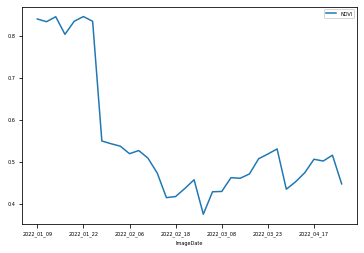

In [46]:
dateWithNDVI_NoNA.plot(x='ImageDate', y='NDVI')

In [47]:
print(startDate.getInfo())

{'type': 'Date', 'value': 1640995200000}


In [48]:
start = date.fromtimestamp(startDate.getInfo()["value"]/1000)
end = date.fromtimestamp(endDate.getInfo()["value"]/1000)
print (start)
print(end)

2021-12-31
2022-04-29


In [49]:
#type(dateWithNDVI_NoNA['ImageDate'][0])

In [50]:
ndviDates = np.array([datetime.strptime(d, "%Y_%m_%d").date() for d in dateWithNDVI_NoNA['ImageDate']], dtype='datetime64')

In [51]:
type(dateWithNDVI_NoNA['NDVI'])

pandas.core.series.Series

In [52]:
ndvi_np = np.array(dateWithNDVI_NoNA['NDVI'])

In [53]:
print(ndvi_np)

[0.84004016 0.83350173 0.8453676  0.80341662 0.83454507 0.84578351
 0.83452106 0.54938392 0.54284503 0.53703435 0.51914698 0.52660123
 0.50843915 0.47324242 0.41446818 0.41710196 0.43632048 0.45703029
 0.37493752 0.42845074 0.42919352 0.46204044 0.46060067 0.47088023
 0.50711642 0.51832529 0.5304076  0.43457145 0.45210833 0.47381533
 0.50588225 0.50167504 0.51554043 0.44722215]


In [54]:
print(splot_index)

1


In [55]:
print(len(dateMeans))
print(len(allMeans))
print(len(allPixels))


36
19
19
